In [63]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np

In [64]:
data = datasets.load_iris(as_frame=True)
df = data.frame
df.head()
X = df.drop(columns=['target'])
y = df['target']

In [65]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [66]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

## 1. Implementando as seguintes métricas de classificação

In [67]:
def accuracy(y_pred, y_true):
  total_itens = len(y_pred)
  total_true_predict = 0

  for i in range(total_itens):
    if(y_pred[i]==y_true[i]):
      total_true_predict+=1
  
  acc = float(total_true_predict/total_itens)
  return acc

def precision(y_pred, y_true): #vp/vp+fp
  c_m = confusion_matrix(y_true, y_pred)
  avg_prec = 0
  sum_prec = 0
  vp = 0
  for i in range(len(c_m)):    
    vp = c_m[i,i]
    fp = 0
    for j in range(len(c_m)):
      fp+=c_m[i][j]
    fp-=c_m[i,i]
    sum_prec += vp/(vp+fp)
  avg_prec = sum_prec/len(c_m)
  return avg_prec


def recall(y_pred, y_true): #vp/vp+fn
  c_m = confusion_matrix(y_true, y_pred)
  avg_rec = 0
  sum_rec = 0
  vp = 0
  for i in range(len(c_m)):    
    vp = c_m[i,i]
    fn = 0
    for j in range(len(c_m)):
      if j==i:
        continue
      fn = fn+c_m[j][i]
    sum_rec += vp/(vp+fn)
  avg_rec = sum_rec/len(c_m)
  return avg_rec


def f1_score(y_pred, y_true): #2*prec*recall / (prec+recall)
  prec = precision(y_pred, y_true)
  rec = recall(y_pred, y_true)
  score = (2*prec*rec) / (prec+rec)
  return score


## 2. Dividindo de forma estratificada o Dataset Iris em apenas 10% para treino e 90% para teste.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y, random_state=42)

In [69]:
y_train

29     0
145    2
8      0
148    2
25     0
      ..
63     1
65     1
37     0
2      0
33     0
Name: target, Length: 135, dtype: int64

## 3. Criando um modelo preditivo de classificação multi-classe usando Logistic Regression

In [70]:
clf = LogisticRegression(random_state=42,multi_class='auto', solver='lbfgs').fit(X, y)
clf.score(X_train,y_train)

0.9777777777777777

In [71]:
y_pred = clf.predict(X_test)
y_test = y_test.to_numpy()

In [72]:
confusion_matrix(y_test, y_pred, labels=[0,1,2])

array([[5, 0, 0],
       [0, 4, 1],
       [0, 0, 5]])

In [73]:
y_pred

array([1, 2, 2, 1, 2, 0, 0, 0, 2, 1, 0, 2, 1, 2, 0])

## 4. Avaliando o modelo usando minhas implementações das métricas: accuracy, precision, recall e f1_measure.

In [74]:
acc = accuracy(y_pred,y_test)
prec = precision(y_pred,y_test)
rec = recall(y_pred,y_test)
f1_score = f1_score(y_pred,y_test)
print('Acurária '+str(acc))
print('Precisão '+str(prec))
print('Recall '+str(rec))
print('F1-score '+str(f1_score))

Acurária 0.9333333333333333
Precisão 0.9333333333333332
Recall 0.9444444444444445
F1-score 0.9388560157790926


## Executando as métricas do sklearn para comparação

In [75]:
from sklearn.metrics import classification_report

In [76]:
print(classification_report(y_test, y_pred, target_names=['0','1','2']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5

    accuracy                           0.93        15
   macro avg       0.94      0.93      0.93        15
weighted avg       0.94      0.93      0.93        15



In [77]:
print(y_test)
print(y_pred)

[1 2 2 1 2 0 0 0 2 1 0 2 1 1 0]
[1 2 2 1 2 0 0 0 2 1 0 2 1 2 0]


## 5. Desenhando a curva ROC para a classe Iris-virginica

Para fazer a curva ROC para a classe virgínica, precisamos da abordagem One-vs-Rest onde o rótulo indicará classe virgínica ou classe não virgínica

In [78]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(15, 3)

In [79]:
y_onehot_test

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [81]:
# Obtendo as probabilidades previstas para a classe "virginica"
y_score = clf.predict_proba(X_test)[:, 2]

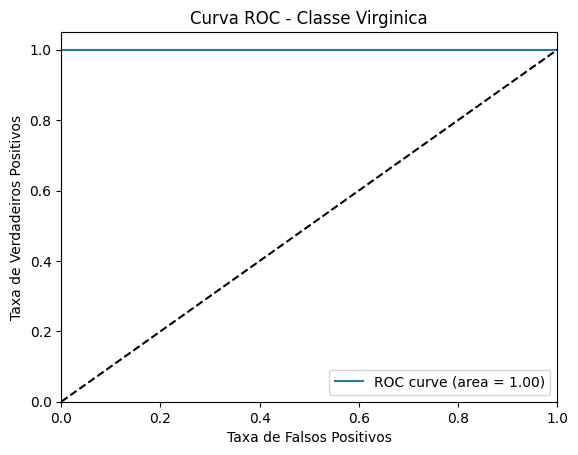

In [82]:
fpr, tpr, thresholds = roc_curve(y_onehot_test[:,2], y_score)
roc_auc = auc(fpr, tpr)

# Plotando a curva ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal para representar o classificador aleatório
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Classe Virginica')
plt.legend(loc="lower right")
plt.show()

## 6. Calculando métrica AUC (Area Under Curve) para a classe Iris-virginica

In [83]:
auc = roc_auc_score(y_onehot_test[:,2], y_score)
print(auc)

1.0
